In [1]:
from google.colab import drive
import os
import gdown # Library to download files from Google Drive
!gdown 1ba77UQl24FgekMX58BrNtba_zcFAo1Dv # Google Drive ID of the zip file to be downloaded


Downloading...
From (original): https://drive.google.com/uc?id=1ba77UQl24FgekMX58BrNtba_zcFAo1Dv
From (redirected): https://drive.google.com/uc?id=1ba77UQl24FgekMX58BrNtba_zcFAo1Dv&confirm=t&uuid=1b959396-91c2-4180-a7a9-5f01230f8760
To: /content/images.zip
100% 273M/273M [00:03<00:00, 82.4MB/s]


In [2]:
!unzip -oq images # Unzip the file downloaded. Options -o and -q overwrites the files if exists already and disables printing out the extracted files, respectively.

In [3]:

root_dir = '/content/images'


In [4]:
import gdown

# Define the Google Drive file ID for the responses.json file
file_id = '1nktUlbNE4lZHrJ83d0B3msZy_R12Sa3o'

# Define the output path for the downloaded file
output_path = '/content/ad_responses.json'

# Download the file using gdown
gdown.download(f'https://drive.google.com/uc?id={file_id}', output_path, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1nktUlbNE4lZHrJ83d0B3msZy_R12Sa3o
To: /content/ad_responses.json
100%|██████████| 11.5M/11.5M [00:00<00:00, 83.0MB/s]


'/content/ad_responses.json'

In [5]:
import json
import os
from PIL import Image
import numpy as np
import pickle

# Load the JSON data
responses_file = '/content/ad_responses.json'
with open(responses_file, 'r') as f:
    data = json.load(f)

# Create a dictionary to map '_id' to ad_info for faster lookup
ad_info_dict = {info['_id']: info for info in data.values() if '_id' in info}
# Define the root directory for images
images_dir = '/content/images'

# Define the target dimensions for resizing images (lower resolution for efficiency)
target_width = 512   # Lower resolution
target_height = 512  # Lower resolution

# Initialize lists to store calculated and extracted features
campaign_data = []

# Iterate through each image in the images directory
for filename in os.listdir(images_dir):
    if filename.endswith(".jpg"):  # Check if the file is a JPEG image
        image_id = filename.split('.')[0]  # Extract ID from filename
        for key, value in ad_info_dict.items():
            if '_id' in value and value['_id'] == image_id:
                ad_info = value
                image_path = os.path.join(images_dir, filename)

                # Load and preprocess the image
                with Image.open(image_path) as img:
                    img = img.convert('RGB')  # Convert image to RGB format
                    img = img.resize((target_width, target_height))  # Resize image to lower resolution
                    img_array = np.array(img)  # Convert image to numpy array

                # Process only the necessary data to reduce memory load
                avg_spend = np.mean([int(ad_info.get("spend", {}).get("lower_bound", 0)), int(ad_info.get("spend", {}).get("upper_bound", 0))])
                avg_impressions = np.mean([int(ad_info.get("impressions", {}).get("lower_bound", 0)), int(ad_info.get("impressions", {}).get("upper_bound", 0))])
                cost_per_impression = avg_spend / avg_impressions if avg_impressions > 0 else float('inf')

                # Append only necessary info to reduce memory footprint
                campaign_data.append({
                    "ad_id": ad_info.get('_id', ''),
                    "cpi": cost_per_impression,
                    "image_data": img_array.flatten().tolist()  # Flatten and convert to list to minimize size
                })
                break

# Normalize CPI values
cpi_values = [entry["cpi"] for entry in campaign_data]
cpi_min = min(cpi_values)
cpi_max = max(cpi_values)
for entry in campaign_data:
    entry["cpi"] = (entry["cpi"] - cpi_min) / (cpi_max - cpi_min) if cpi_max > cpi_min else 0

# Save the normalized data
with open('/content/campaign_data.pkl', 'wb') as f:
    pickle.dump(campaign_data, f)

# Clear the large variables from memory
del campaign_data
del data


In [6]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, image_filenames, labels, batch_size, image_directory, dim=(512, 512), n_channels=3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.image_filenames = image_filenames
        self.image_directory = image_directory
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        image_filenames_temp = [self.image_filenames[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(image_filenames_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, image_filenames_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=float)

        # Generate data
        for i, image_filename in enumerate(image_filenames_temp):
            # Store sample
            img = load_img(os.path.join(self.image_directory, image_filename + '.jpg'), target_size=self.dim)
            X[i,] = img_to_array(img) / 255.0

            # Store class
            y[i] = self.labels[image_filename]

        return X, y


In [7]:
import pickle

# Load the processed data from disk
with open('/content/campaign_data.pkl', 'rb') as f:
    campaign_data = pickle.load(f)

# Print the maximum and minimum CPI values
print("Maximum CPI value:", max_cpi)
print("Minimum CPI value:", min_cpi)
# Print the first few entries of the campaign data to verify
for campaign in campaign_data[:3]:  # Adjust the range as needed for more samples
    print("Ad ID:", campaign["ad_id"])
    print("Cost Per Impression (CPI):", campaign["cpi"])
    print("Sample Image Data (flattened):", campaign["image_data"][:10])  # Show only the first 10 pixels to keep output manageable
    print("\n")




Maximum CPI value: 1.0
Minimum CPI value: 0.0
Ad ID: 331418814108624
Cost Per Impression (CPI): 0.1768879805497505
Sample Image Data (flattened): [111, 111, 111, 105, 105, 105, 90, 90, 90, 65]


Ad ID: 307653333296084
Cost Per Impression (CPI): 0.05671576340074205
Sample Image Data (flattened): [183, 173, 172, 183, 173, 172, 181, 171, 170, 178]


Ad ID: 2262728950613044
Cost Per Impression (CPI): 0.07416908368425874
Sample Image Data (flattened): [112, 121, 118, 112, 121, 118, 113, 122, 119, 113]




In [10]:
import tensorflow as tf

# Check TensorFlow GPU usage
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow will run on GPU")
else:
    print("TensorFlow will run on CPU")

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


Num GPUs Available:  1
TensorFlow will run on GPU
1 Physical GPUs, 1 Logical GPUs


In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split


def create_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1)  # Assuming CPI prediction is a regression task
    ])
    return model



# Assuming you have a dictionary mapping from image IDs to CPI and file names
image_filenames = [campaign['ad_id'] for campaign in campaign_data]  # ID is used as filename
labels = {campaign['ad_id']: campaign['cpi'] for campaign in campaign_data}
image_directory = '/content/images'

# Splitting the dataset
image_filenames_train, image_filenames_test, labels_train, labels_test = train_test_split(
    image_filenames, [labels[id] for id in image_filenames], test_size=0.2, random_state=42)

# Create the generator
batch_size = 10  # Depends on your available memory
train_generator = DataGenerator(image_filenames=image_filenames_train, labels=dict(zip(image_filenames_train, labels_train)), batch_size=batch_size, image_directory=image_directory)
test_generator = DataGenerator(image_filenames=image_filenames_test, labels=dict(zip(image_filenames_test, labels_test)), batch_size=batch_size, image_directory=image_directory)

# Define your model's input shape based on the data dimensions you will train on
input_shape = (512, 512, 3)  # Modify according to your resized image dimensions

# Create the model
model = create_model(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_squared_error'])

# Show the model structure
model.summary()
# Now use this generator directly in model.fit
model.fit(train_generator, epochs=10, validation_data=test_generator)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 510, 510, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 255, 255, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 126, 126, 64)      0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1016064)           0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [21]:
#abs - squared error
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Mean Absolute Error (MAE): {test_mae}")

12/12 [==============================] - 2s 162ms/step - loss: 0.0359 - mean_squared_error: 0.0027
Test Loss: 0.03587152808904648
Mean Absolute Error (MAE): 0.0027326862327754498


In [ ]:
#squared error - abs error
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Mean Absolute Error (MAE): {test_mae}")



12/12 [==============================] - 2s 164ms/step - loss: 0.0280 - mean_squared_error: 0.0024
Test Loss: 0.028036927804350853
Mean Absolute Error (MAE): 0.0024414174258708954


In [29]:
test_cpis = []
for batch_images, batch_labels in test_generator:
    test_cpis.extend(batch_labels)  # Assuming batch_images contains the image filenames, which are the IDs

# Now test_ids contains all the IDs in the test generator
print("CPIs in the test generator:", test_cpis)


CPIs in the test generator: [0.0032777069398280227, 0.1768879805497505, 0.045737568609798, 0.056245005061584405, 0.008032857913370018, 0.006934342913995963, 0.03797327547770541, 0.1768879805497505, 0.024194280576072452, 0.07396936349524504, 0.01622691391820025, 0.01999392640588186, 0.045130206002987235, 0.016259007290586793, 0.005496088797495586, 0.1263273524494444, 0.02201081491907308, 0.021805132933372395, 0.024179575450334334, 0.02273366861784952, 0.039125237967003304, 0.07880210746674683, 0.017865637714736857, 0.06163098614765702, 0.007793681381026724, 0.04576339755490265, 0.021805132933372395, 0.06605985519172546, 0.09638381198619723, 0.01423542540735111, 0.06163098614765702, 0.03247253673372852, 0.017817539645491334, 0.032490331083216036, 0.02434037087730038, 0.23329535562465223, 0.04287412242514734, 0.011792663769532136, 0.08105721614442807, 0.042224771110724785, 0.07396936349524504, 0.03244246867211022, 0.11212013005683279, 0.017865637714736857, 0.13548074661264825, 0.032135716

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras.models import load_model

# Assuming 'model' and 'test_generator' are defined and loaded appropriately
# Load your model if it is not already loaded
# model = load_model('path_to_your_model.h5')

# Extract labels and predictions without assuming reset functionality
test_cpis = []
predictions = []
for batch_images, batch_labels in test_generator:
    test_cpis.extend(batch_labels)
    predictions.extend(model.predict_on_batch(batch_images))

# Convert data to numpy arrays for easier manipulation
test_cpis = np.array(test_cpis)
predictions = np.array(predictions)

# Initialize accuracy counts for each order position
num_trials = 500
accuracy_counts = np.zeros(4)

# Print lengths to verify data sizes
print("Predicted data length:", len(predictions))
print("Actual data length:", len(test_cpis))

# Validate if we have enough elements to randomly pick 4
if len(predictions) >= 4 and len(test_cpis) >= 4:
    for _ in range(num_trials):
        # Randomly pick 4 indices ensuring no out of bound error
        indices = np.arange(min(len(predictions), len(test_cpis)))
        selected_indices = shuffle(indices)[:4]  # No fixed seed for true randomness each trial

        # Extract selected predictions and actual values
        selected_predictions = predictions[selected_indices]
        selected_actuals = test_cpis[selected_indices]

        # Order by predictions
        order_pred_indices = np.argsort(selected_predictions[:, 0])  # Assuming predictions are in the first column
        order_actual_indices = np.argsort(selected_actuals)

        # Compare orders
        accuracy_positions = [1 if pred_i == act_i else 0 for pred_i, act_i in zip(order_pred_indices, order_actual_indices)]
        accuracy_counts += accuracy_positions

    # Calculate average accuracies for each order
    average_accuracies = accuracy_counts / num_trials
    print("Average Accuracy at first position:", average_accuracies[0])
    print("Average Accuracy at second position:", average_accuracies[1])
    print("Average Accuracy at third position:", average_accuracies[2])
    print("Average Accuracy at fourth position:", average_accuracies[3])
else:
    print("Not enough data points to select 4 unique values. Please ensure at least 4 data points are available.")


Predicted data length: 120
Actual data length: 120
Average Accuracy at first position: 0.308
Average Accuracy at second position: 0.306
Average Accuracy at third position: 0.266
Average Accuracy at fourth position: 0.324


In [24]:
import numpy as np
from sklearn.metrics import roc_auc_score

# First, gather all predictions and actuals
y_true = []
y_pred = []
for batch_images, batch_labels in test_generator:
    preds = model.predict_on_batch(batch_images)
    y_pred.extend(preds)
    y_true.extend(batch_labels)

# Convert lists to numpy arrays for easier manipulation
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate the concordance index, treating it similar to AUC calculation
def calculate_concordance_index(y_true, y_pred):
    n = 0
    h_sum = 0
    for i in range(len(y_true)):
        for j in range(i + 1, len(y_true)):
            if y_true[i] != y_true[j]:
                n += 1
                if (y_pred[i] > y_pred[j] and y_true[i] > y_true[j]) or (y_pred[i] < y_pred[j] and y_true[i] < y_true[j]):
                    h_sum += 1
                elif y_pred[i] == y_pred[j]:
                    h_sum += 0.5
    return h_sum / n if n > 0 else 0

# Calculate the C-index
c_index = calculate_concordance_index(y_true, y_pred)
print("Concordance Index:", c_index)


Concordance Index: 0.5298055242390078


12/12 [==============================] - 3s 253ms/step
[0.04939401]
0.050736651364387736
[0.0360022]
0.01622691391820025
[0.03646702]
0.05663732111498065
[0.04157696]
0.01999392640588186
[0.03682003]
0.04871225816748372
[0.03723488]
0.04576339755490265
[0.0608006]
0.021232120108233898
[0.03549018]
0.13289355695645189
[0.04038426]
0.1768879805497505
[0.03534421]
0.09798622336999258
[0.04053415]
0.1263273524494444
[0.03643629]
0.07104799473855919


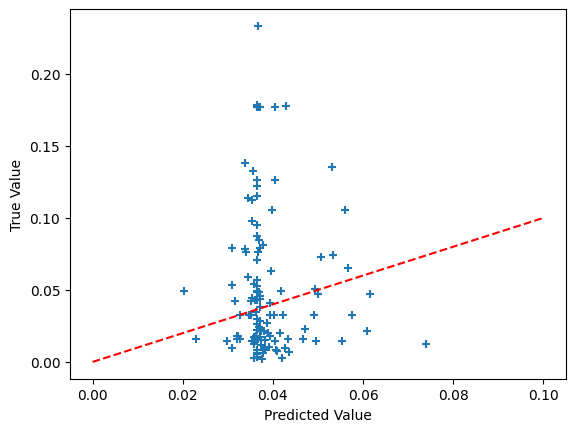

In [22]:
#abs error - squared error

import matplotlib.pyplot as plt

test_predict = model.predict(test_generator)
count = 0
for i in range (0,12):
  print(test_predict[i])
  print(test_cpis[i])
# Create the scatter plot
plt.figure()
plt.scatter(test_predict, test_cpis, marker="+")
plt.xlabel("Predicted Value")
plt.ylabel("True Value")

# Add a reference line
plt.plot([0, 0.1], [0, 0.1], "r--")  # Assuming the range of values is -60 to 60, adjust as needed

# Show the plot
plt.show()